# Computer Lab 4: Forecasting Daily Data using Facebook Prophet

**In this practical you will learn:**

* How to wrangle time series data into `Prophet` format
* How to fit a `Prophet` model to a time series
* How to obtain a point forecast and prediction intervals using `Prophet`
* How to model special calender events.
* How to use `Prophet`'s built in diagnostic and cross validation tools

## Standard Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## FB Prophet Imports

If you are using the provided conda environment `hds_forecast` you will already have `fbprophet` installed.  Prophet is also installed by default in Google Colab.

In [2]:
from fbprophet import Prophet

import fbprophet

#should be version 0.6
fbprophet.__version__

'0.6'

## forecast-tools imports

In [66]:
#uncomment if running in colab
#!pip install forecast-tools

In [65]:
from forecast_tools.model_selection import auto_naive
from forecast_tools.metrics import mean_absolute_error

# ARIMA imports

At the end of the notebook we will compare Prophet's performance to ARIMA

In [33]:
#uncomment if you need to install
#!pip install pmdarima

from pmdarima import auto_arima, ARIMA

# Data - ED reattendances

We will use an time series of patients that reattend an ED within 7 days.  The data are held at the **daily** level.

The data is held in the file `ed_reattends_day.csv`

# Exercise 1: Read in and adjust

**Task:**

* Load `ed_reattends_day.csv` (url provided below)
* Plot the data
* Name the `pd.DataFrame` you create `y_train`

**Hints**

* The data is stored in UK day first format.
* Remember to set the freq of the DataTimeIndex

**Questions**:
* How would you describe the time series?

In [36]:
#your code here ...
url = 'https://raw.githubusercontent.com/health-data-science-OR/hpdm097-datasets/master/ed_reattends_day.csv'

In [37]:
#example solution

y_train = pd.read_csv(url, parse_dates=True, 
                            dayfirst=True, index_col='date')
y_train.index.freq = 'D'

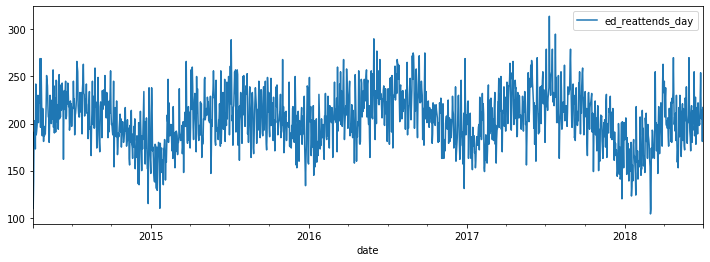

In [38]:
y_train.plot(figsize=(12,4))

# Exercise 2: Wrangle the data into Prophet Format

A `Prophet` model requires the data in a `pd.DataFrame` with two columns: 'ds' - the datetimestamp and `y` the observations used in training (the index is an arbitrary numeric value).  But your current (and standard form) dataframe has a datetimeindex 

**Task:**

* Code a function that converts the training data into the correct format for Prophet.
* The end product should be a dataframe with 2 columns (in the following order)
 * 'ds': the date
 * 'y': the number of reattends on that day.
* Convert your data

In [39]:
# your code goes here...

In [40]:
#example solution

def prophet_training_data(y_train):
    '''
    Converts a standard pandas datetimeindexed dataframe
    for time series into one suitable for Prophet
    Parameters:
    ---------
    y_train: pd.DataFrame
        univariate time series data
        
    Returns:
    --------
        pd.DataFrame in Prophet format 
        columns = ['ds', 'y']
    '''
    prophet_train = pd.DataFrame(y_train.index)
    prophet_train['y'] = y_train.to_numpy()
    prophet_train.columns = ['ds', 'y']

    return prophet_train

In [41]:
yp_train = prophet_training_data(y_train)

In [42]:
yp_train.head()

,ds,y
0,2014-04-03,110.0
1,2014-04-04,138.0
2,2014-04-05,191.0
3,2014-04-06,176.0
4,2014-04-07,203.0


# Exercise 3: Fit and predict using a basic Prophet model

Fitting a basic Prophet model is relatively straightforward.  We need to create a `Prophet` object

```python
model = Prophet()
```
Unlike ARIMA where we specified the prediction interval width at prediction time, with Prophet we need to specify the interval width as we create the model.  We do this using the parameter `interval_width`.  By default this produces a 80\% prediction interval.  Note we specify a $1-\alpha$ interval width (unlike in ARIMA where we specified $\alpha$)

```python
model = Prophet(interval_width=0.95)
```

and call `.fit()` passing in the training data.

```python
model.fit(y_train)
```

## Exercise 3.1 Fitting
**Task:**

* Fit a basic `Prophet` model to the training data
* Set the model up to produce 95\% prediction intervals

In [11]:
# your code here ...

In [43]:
#example solution
model = Prophet(interval_width=0.95)
model.fit(yp_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Exercise 3.2 Forecasting

There are two steps to makeing a forecast with a fitted `Prophet` model.  You must first create a future dataframe.  This is a `pd.DataFrame` with a single column 'ds' that runs from the start of the training period until the end of the training period + a horizon.  Prophet makes this easy by including a `make_future_dataframe()` method.

```python
future = model.make_future_dataframe(periods=28)
```

Once we have the future dataframe we can pass that to the predict method.

```python
prophet_forecast = model.predict(future)
```

This returns a `pd.DataFrame` that contains both the in-sample fitted values and the out of sample forecasts. It contains all of the components of the fitted model. For example the last 5 rows of a forecast are:

|      | ds                  |   trend |   yhat_lower |   yhat_upper |   trend_lower |   trend_upper |   additive_terms |   additive_terms_lower |   additive_terms_upper |    weekly |   weekly_lower |   weekly_upper |   yearly |   yearly_lower |   yearly_upper |   multiplicative_terms |   multiplicative_terms_lower |   multiplicative_terms_upper |    yhat |
|-----:|:--------------------|--------:|-------------:|-------------:|--------------:|--------------:|-----------------:|-----------------------:|-----------------------:|----------:|---------------:|---------------:|---------:|---------------:|---------------:|-----------------------:|-----------------------------:|-----------------------------:|--------:|
| 1629 | 2018-09-18 00:00:00 | 187.353 |      163.694 |      236.271 |       186.22  |       188.383 |        11.0807   |              11.0807   |              11.0807   |  -2.83494 |       -2.83494 |       -2.83494 |  13.9156 |        13.9156 |        13.9156 |                      0 |                            0 |                            0 | 198.433 |
| 1630 | 2018-09-19 00:00:00 | 187.305 |      157.7   |      226.979 |       186.153 |       188.356 |         5.91039  |               5.91039  |               5.91039  |  -7.49286 |       -7.49286 |       -7.49286 |  13.4032 |        13.4032 |        13.4032 |                      0 |                            0 |                            0 | 193.215 |
| 1631 | 2018-09-20 00:00:00 | 187.257 |      150.343 |      224.271 |       186.088 |       188.328 |         0.527382 |               0.527382 |               0.527382 | -12.3179  |      -12.3179  |      -12.3179  |  12.8452 |        12.8452 |        12.8452 |                      0 |                            0 |                            0 | 187.785 |
| 1632 | 2018-09-21 00:00:00 | 187.209 |      156.873 |      226.588 |       186.023 |       188.3   |         3.90459  |               3.90459  |               3.90459  |  -8.34281 |       -8.34281 |       -8.34281 |  12.2474 |        12.2474 |        12.2474 |                      0 |                            0 |                            0 | 191.114 |
| 1633 | 2018-09-22 00:00:00 | 187.162 |      169.299 |      241.272 |       185.954 |       188.272 |        15.9777   |              15.9777   |              15.9777   |   4.36149 |        4.36149 |        4.36149 |  11.6162 |        11.6162 |        11.6162 |                      0 |                            0 |                            0 | 203.139 |


We can the plot the forecast using Prophet's built in functionality

```python
model.plot(prophet_forecast);
```

In the plot you will see

* Black dots - these represent the actual observations (training data)
* Blue line - this represents the point forecast
* Light blue shaded region - this is the 95\% prediction interval

**Task:**
* Use your Prophet model to make a 84 day prediction.
* Plot the prediction

In [13]:
# your code here ...

In [44]:
#example solution
future = model.make_future_dataframe(periods=84)
future

,ds
0,2014-04-03
1,2014-04-04
2,2014-04-05
3,2014-04-06
4,2014-04-07
...,...
1629,2018-09-18
1630,2018-09-19
1631,2018-09-20
1632,2018-09-21


In [45]:
prophet_forecast = model.predict(future)
prophet_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1629,2018-09-18,187.176621,156.889425,241.514226,186.367090,188.089093,12.043062,12.043062,12.043062,-2.057906,-2.057906,-2.057906,14.100968,14.100968,14.100968,0.0,0.0,0.0,199.219683
1630,2018-09-19,187.128896,152.382316,232.565111,186.298525,188.059228,5.654988,5.654988,5.654988,-7.972559,-7.972559,-7.972559,13.627547,13.627547,13.627547,0.0,0.0,0.0,192.783884
1631,2018-09-20,187.081171,147.702180,226.972356,186.229960,188.031951,1.306832,1.306832,1.306832,-11.806860,-11.806860,-11.806860,13.113692,13.113692,13.113692,0.0,0.0,0.0,188.388003
1632,2018-09-21,187.033446,149.970248,235.576452,186.161395,187.998101,4.158388,4.158388,4.158388,-8.407174,-8.407174,-8.407174,12.565562,12.565562,12.565562,0.0,0.0,0.0,191.191834
1633,2018-09-22,186.985721,161.025793,242.136157,186.092830,187.964896,15.436583,15.436583,15.436583,3.446945,3.446945,3.446945,11.989638,11.989638,11.989638,0.0,0.0,0.0,202.422304


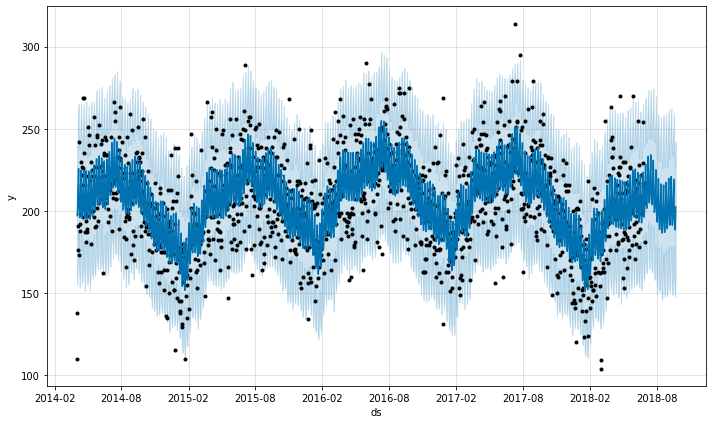

In [46]:
model.plot(prophet_forecast);

# Exercise 4: Plot the model components

To decompose the Prophet model and see the trend and seasonal components you can call:

```python
model.plot_components(forecast)
```

**Task:**

* Plot the Prophet model's trend and seasonal components.


**Questions:**
* What observations can you make about the weekly (i.e. days of the week) and yearly (i.e months of the year) seasonality?

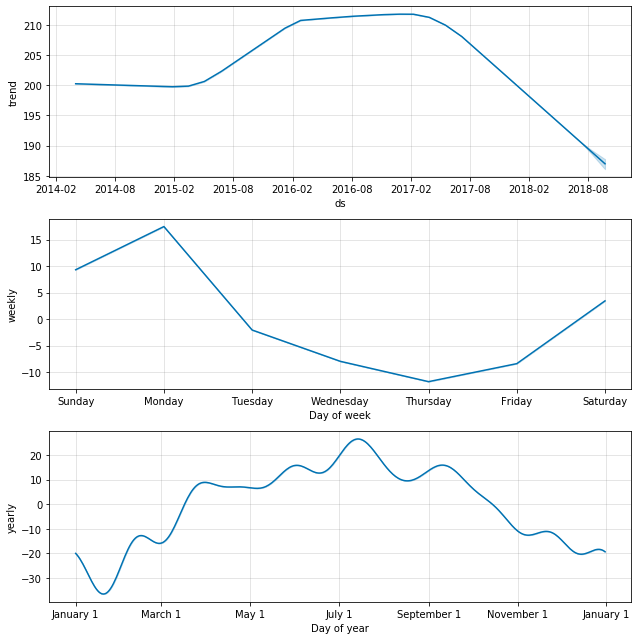

In [17]:
model.plot_components(prophet_forecast);


# Exercise 5: Adding standard holidays

As this is ED reattendance data at the daily level, it is likely that we will be seeing some calender day/holiday effects.  Prophet has been designed to deal with 'holidays'.  Effectively a series of binary variables are added for each holiday.

Prophet has a number of standard holidays built in by country.  To add them in for 'England' you would use the following code:

```python
model = Prophet(interval_width=0.95)
model.add_country_holidays(country_name='England')
model.fit(y_train)
```

Note that you call the `add_country_holidays` **before** you fit the model.  This is because it is command telling Prophet what you would like to fit.

To see what models have been fitted you can call:

```python
model.train_holiday_names.to_list()
```

When you plot the components of the model a new panel will be added for holidays.  It can sometimes be a bit difficult to which holidays are having which effect so you can plot individual holidays as follows:

```python
from fbprophet.plot import plot_forecast_component

plot_forecast_component(model, prophet_forecast, 'Christmas Day');
```

**Task:**

* Modify your code to include a holidays for 'England'
* Make an 84 day forecast
* Plot the model components. 
* Explore the holidays

**Questions:**

* What do you notice about Christmas day, Easter Monday and Good Friday?  Are there any other days that appear important?

**Hints:**
* Take a look at the new forecast dataframe.  This includes new columns with the effect of each `holidays`.

In [18]:
#your code here ...

In [49]:
#example solution
model = Prophet(interval_width=0.95)
model.add_country_holidays(country_name='England')
model.fit(yp_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [50]:
model.train_holiday_names.to_list()

["New Year's Day",
 'Good Friday',
 'Easter Monday',
 'May Day',
 'Spring Bank Holiday',
 'Late Summer Bank Holiday',
 'Christmas Day',
 'Christmas Day (Observed)',
 'Boxing Day',
 "New Year's Day (Observed)",
 'Boxing Day (Observed)']

In [21]:
future = model.make_future_dataframe(periods=84)
prophet_forecast = model.predict(future)

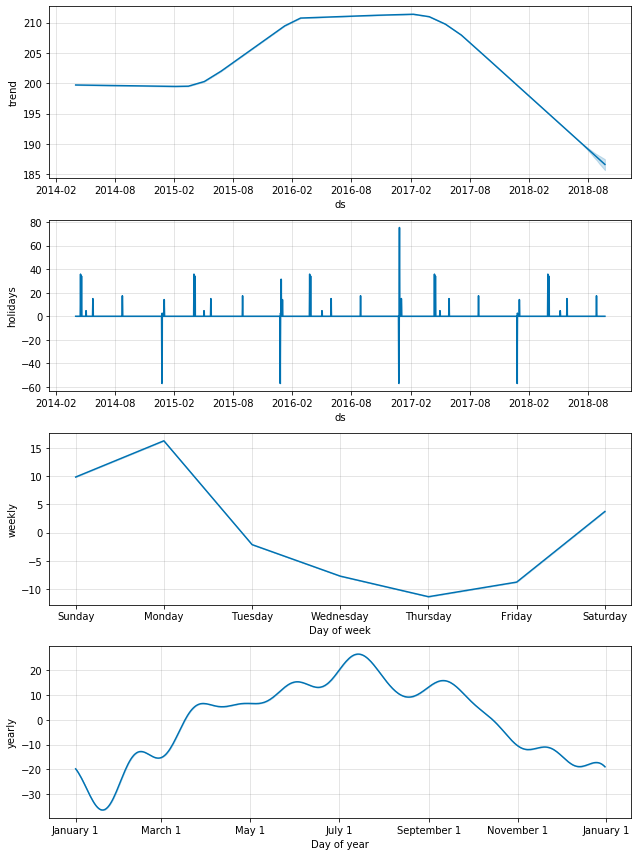

In [22]:
model.plot_components(prophet_forecast);

In [23]:
prophet_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Boxing Day', 'Boxing Day_lower', 'Boxing Day_upper',
       'Boxing Day (Observed)', 'Boxing Day (Observed)_lower',
       'Boxing Day (Observed)_upper', 'Christmas Day', 'Christmas Day_lower',
       'Christmas Day_upper', 'Christmas Day (Observed)',
       'Christmas Day (Observed)_lower', 'Christmas Day (Observed)_upper',
       'Easter Monday', 'Easter Monday_lower', 'Easter Monday_upper',
       'Good Friday', 'Good Friday_lower', 'Good Friday_upper',
       'Late Summer Bank Holiday', 'Late Summer Bank Holiday_lower',
       'Late Summer Bank Holiday_upper', 'May Day', 'May Day_lower',
       'May Day_upper', 'New Year's Day', 'New Year's Day_lower',
       'New Year's Day_upper', 'New Year's Day (Observed)',
       'New Year's Day (Observed)_lower', 'New Year's Day (Observed)_upper',
       'Spring Bank Holiday', 'Spring Bank Holiday_lower',
       'Spring Bank Holiday_upper', 'additive_terms

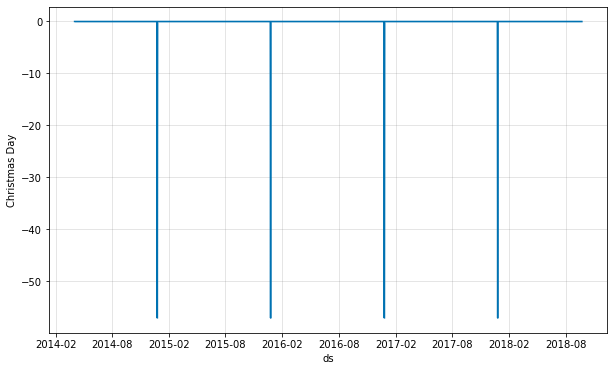

In [24]:
from fbprophet.plot import plot_forecast_component
plot_forecast_component(model, prophet_forecast, 'Christmas Day');

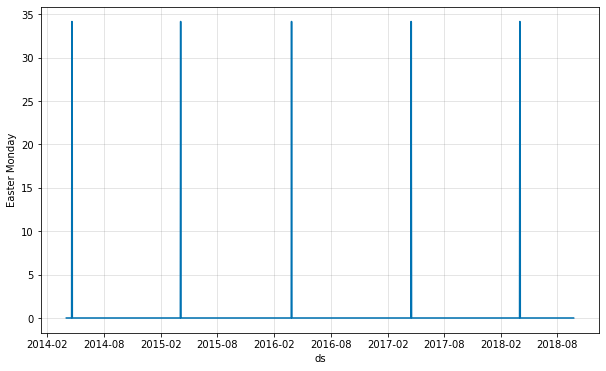

In [25]:
plot_forecast_component(model, prophet_forecast, 'Easter Monday');

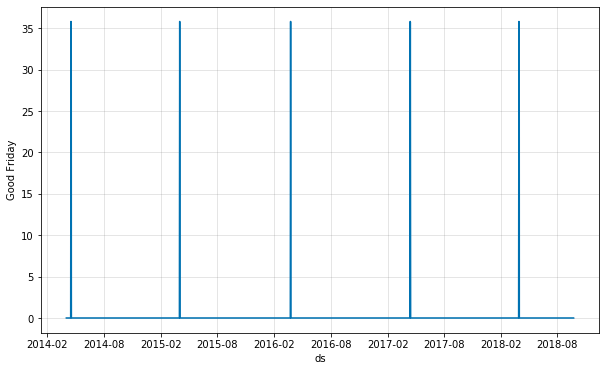

In [26]:
plot_forecast_component(model, prophet_forecast, 'Good Friday');

In [27]:
# Adding a day of month seasonality.

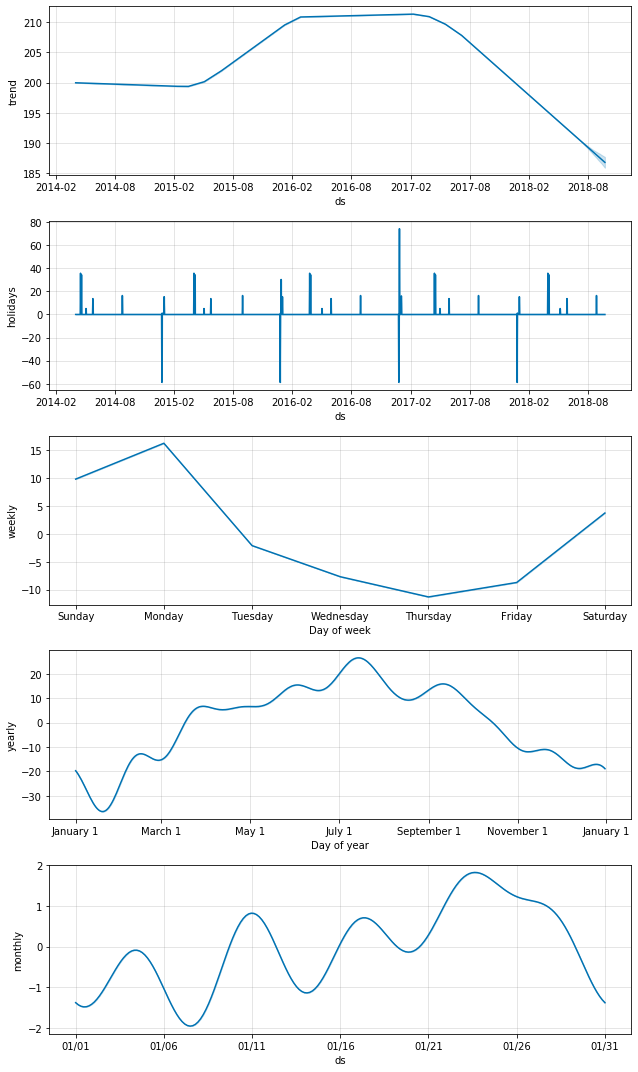

In [51]:
model = Prophet(interval_width=0.95, daily_seasonality=False)
model.add_country_holidays(country_name='England')
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(yp_train)
future = model.make_future_dataframe(periods=84)
prophet_forecast = model.predict(future)
model.plot_components(prophet_forecast);

# Exercise 6: Cross Validation

FBProphet provides its own cross validation procedures in the `diagnostics` module.  Two key functions are the `cross_validation` and `performance_metrics` functions.

```python
from fbprophet.diagnostics import cross_validation, performance_metrics
```

Prophet uses a rolling origin forecast type procedure for cross validation (but rather than working forwards Prophet works backwards from the final fold).  The `cross_validation` function requires some parameters to be **time delta** compatable.  This means that we need to pass in a `str` such as `"7 days"`

To use the `cross_validation` function with your model to do a CV where the initial length of the training set is 1095 days (3 years), the step size (period) is 28 days and the forecast horizon is 84 days we would use the following code:

```python
df_cv = cross_validation(model=model, initial='1095 days', period='28 days', 
                         horizon='84 days')
```

The variable `df_cv` is of type `pandas.DataFrame`.  It contains all of the predictions and actual values by date and cut off.  In our example above the first row will be day 366; the next 83 rows will be all part of the same cross-validation fold.  See below for example, note that all the select rows (0, 1 and 83) have the same **cut-off** - this the **forecast origin** of the cross validation fold.

```python
df_cv.iloc[[0, 1, 83]
```

|    | ds                  |    yhat |   yhat_lower |   yhat_upper |   y | cutoff              |
|---:|:--------------------|--------:|-------------:|-------------:|----:|:--------------------|
|  0 | 2017-04-09 00:00:00 | 215.292 |      180.674 |      249.161 | 241 | 2017-04-08 00:00:00 |
|  1 | 2017-04-10 00:00:00 | 222.806 |      187.367 |      255.534 | 259 | 2017-04-08 00:00:00 |
| 83 | 2017-07-01 00:00:00 | 234.83  |      200.091 |      270.619 | 221 | 2017-04-08 00:00:00 |


If we then look at rows 84 and 85 we see that the cutoff (forecast origin) has rolled forward.  It is equal to the previous cut-off + 28 days (period in prophet terminology).

```python
df_cv.iloc[[84, 85]
```

|    | ds                  |    yhat |   yhat_lower |   yhat_upper |   y | cutoff              |
|---:|:--------------------|--------:|-------------:|-------------:|----:|:--------------------|
| 84 | 2017-05-07 00:00:00 | 226.971 |      192.175 |      260.083 | 217 | 2017-05-06 00:00:00 |
| 85 | 2017-05-08 00:00:00 | 234.145 |      198.177 |      269.963 | 213 | 2017-05-06 00:00:00 |


So in essence `df_cv` is a record of all of the cross-validation folds stacked on top of each other.  This is useful, because it means have all of the data to calculate any forecast error measure we would like for over any sub-forecast horizon.  Prophet provides the function `performance_metrics` and the plotting function `fbprophet.plot.plot_cross_validation_metric` to automate this for you.  For example:

**Note: mdape is median absolute percentage error**

```python
df_p = performance_metrics(df_cv)
df_p.head()
```
|    | horizon          |     mse |    rmse |     mae |      mape |     mdape |   coverage |
|---:|:-----------------|--------:|--------:|--------:|----------:|----------:|-----------:|
|  0 | 9 days 00:00:00  | 387.234 | 19.6783 | 15.6597 | 0.0798998 | 0.0632103 |   0.91453  |
|  1 | 10 days 00:00:00 | 355.57  | 18.8566 | 14.9167 | 0.0775167 | 0.0632103 |   0.931013 |
|  2 | 11 days 00:00:00 | 317.469 | 17.8176 | 13.8917 | 0.0726941 | 0.0535132 |   0.945665 |
|  3 | 12 days 00:00:00 | 311.386 | 17.6461 | 13.8011 | 0.0719934 | 0.0535132 |   0.954212 |
|  4 | 13 days 00:00:00 | 321.142 | 17.9204 | 13.908  | 0.0719082 | 0.0575246 |   0.948718 |

---
**Task:**
* Run Prophet's built in cross validation
* Use an initial training period of 1095 days, period=28 and horizon of '84 days'
* Use Prophet's built in `cross_validation` and `performance_metrics` functions


In [ ]:
#your code here...

In [29]:
#example answer...
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [30]:
df_cv = cross_validation(model, initial='1095 days', period='28 days', horizon='84 days')

INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-04-08 00:00:00 and 2018-04-07 00:00:00


In [64]:
#rolling window = 0 means that we get an average for each horizon
#rolling window = 1 means that we only get the 84 day horizon
#rolling window between 0 and 1 varies the percentage of points in each horizon.
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,84 days,551.405218,23.482019,18.898904,0.100141,0.079615,0.904762


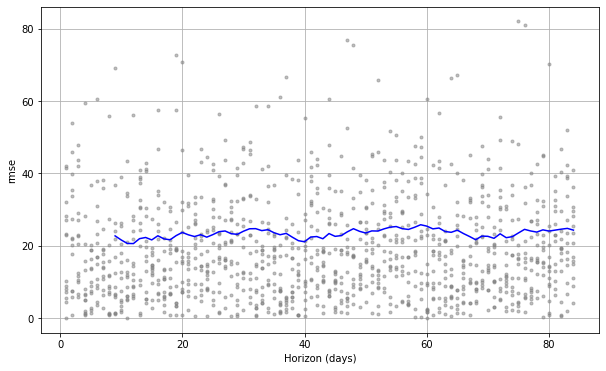

In [32]:
fig = plot_cross_validation_metric(df_cv, metric='rmse', rolling_window=0.1)

# Exercise 7: Is Prophet better than ARIMA?

**Task:**
* Choose and fit an ARIMA model to the dataset.
* Use cross-validation of the 84 day MAE compare the performance of ARIMA and Prophet.

**Questions**
* Which of the two methods would you choose in practice? 
* What else might you do?

**Hints**:
* See Introduction to ARIMA notebook for a reminder about how to use ARIMA models in Python
* This is daily level data.  For ARIMA this is `m=7`
* Remember that Prophet and ARIMA use data in different formats. 
* It might take a few minutes for `auto_arima` to return results.  Once it has write down the order of the model so that you can easily recreate it with a `ARIMA` object.
* It will also take a few minutes for ARIMA cross validation to run.
* If you get a convergence warning when fitting `ARIMA` to your chosen model then try passing the parameter `maxiter=100` (or more) to the `ARIMA` constructor method.

In [ ]:
#your code here

In [60]:
#arima_model = auto_arima(y_train, m=7, suppress_warnings=True)

#model returned = SARIMAX(1, 1, 2)x(1, 0, [1], 7)
arima_model = ARIMA(order=(1, 1, 2), seasonal_order=(1, 0, 1, 7), maxiter=100)
arima_model.fit(y_train)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1550
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -6951.170
Date:                             Thu, 12 Nov 2020   AIC                          13916.341
Time:                                     15:09:28   BIC                          13953.758
Sample:                                          0   HQIC                         13930.258
                                            - 1550                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.206e-05      0.000      0.074      0.941      -0.000       0.000
ar.L1          0.7913      0.075     10.547      0.000       0.644       0.938
ma.L1         -1.5668      0.086    -18.256      0.000      -1.735      -1.399
ma.L2          0.5866      0.078      7.565      0.000       0.435       0.739
ar.S.L7        0.9976      0.002    587.515      0.000       0.994       1.001
ma.S.L7       -0.9717      0.010   -101.257      0.000      -0.991      -0.953
sigma2       466.4673     15.541     30.015      0.000     436.007     496.928
===================================================================================
Ljung-Box (Q):                       43.80   Jarque-Bera (JB):                22.36
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.18
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
#cross validation

from pmdarima.model_selection import RollingForecastCV, cross_val_score

In [62]:
#cv of 84 day forecast
cv = RollingForecastCV(h=84, step=28, initial=1095)
scores1 = cross_val_score(arima_model, y_train, cv=cv, verbose=0, 
                              scoring='mean_absolute_error')

In [63]:
#Prophet 84 day was ~19
scores1.mean()

24.943328884992024

In [ ]:
#naive model?

In [79]:
#selects ensemble naive and produces similar performance to ARIMA 
#(although we haven't checked prediction interval coverage)
naive_results = auto_naive(y_train, horizon=84, min_train_size=1095,
                           seasonal_period=7, step=28, method='ro')
naive_results

{'model': EnsembleNaive(seasonal_period=7), 'mae': 24.739090765103615}